In [1]:
# %matplotlib inline

import math
import random

import matplotlib.pyplot as plt
import numpy as np

from plotting import PlotType, Plotter
from simulating import Simulator

In [2]:
max_acc = 3.0
max_vel = 2.0
global_save_figures = False

1.0151117863833232


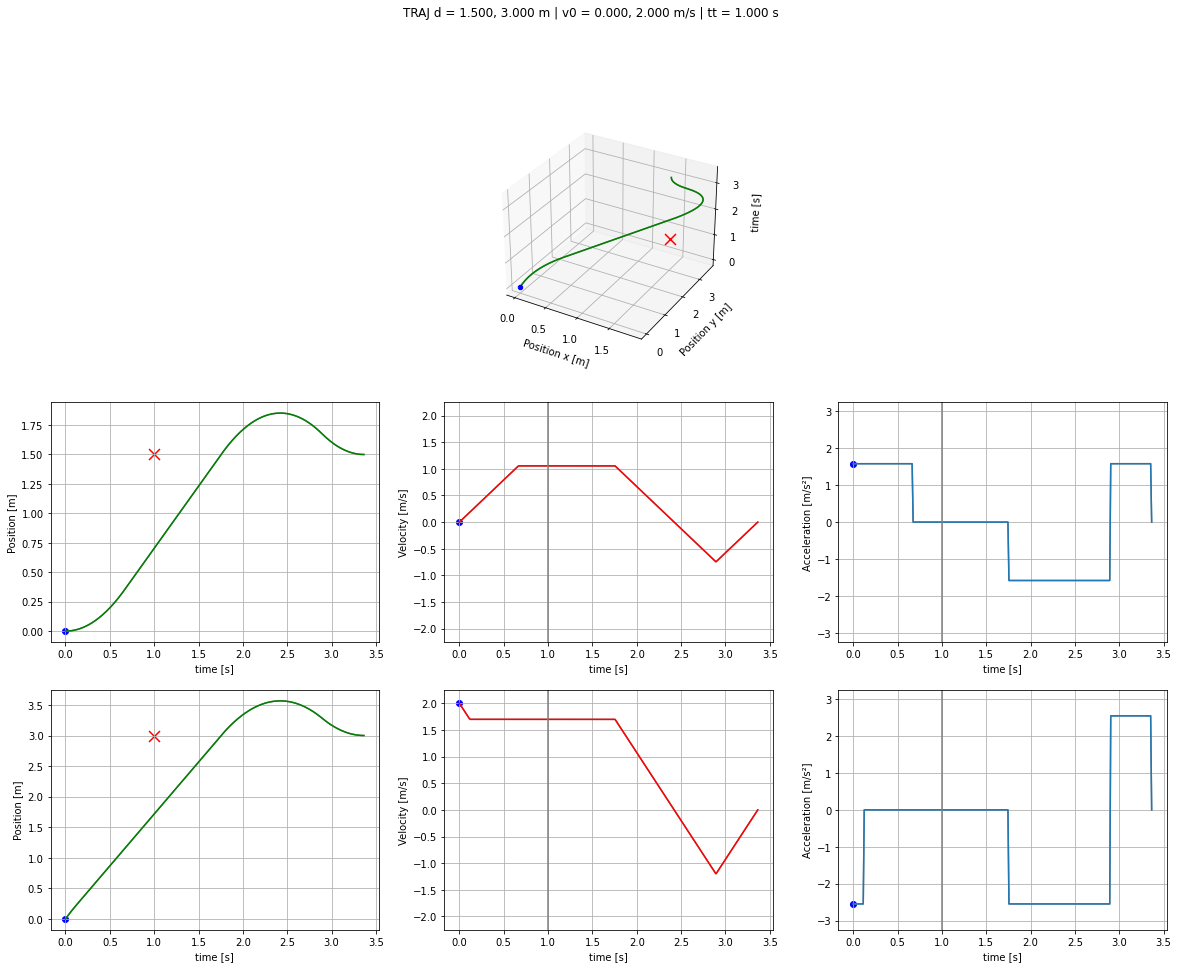

In [3]:
from traj import Vec2

distances = [Vec2(1.5, 3)]
initial_velocities = [Vec2(0, 2)]
target_times = [1]

for d in sorted(set(distances)):
    for i_v in sorted(set(initial_velocities)):
        for tt in sorted(set(target_times)):
            fig = Plotter.plot(d, i_v, tt, max_acc, max_vel, PlotType.TRAJ)

In [4]:
test_values = [
    (0.0, 0.0, 0.0),
    (0.0, 1.0, 0.0),
    (0.0, 1.0, 1.0),
    (0.0, 1.0, 1.1),
    (0.5, 2.0, 0.5),
    (0.5, 2.0, 0.92),
    (1.0, 1.0, 0.5),
    (1.0, 1.0, 0.6),
    (1.0, 1.0, 1.0),
    (2.0, 2.0, 1.1),
    (2.0, 2.0, 2.0),
    (1.0, 0.0, 1.0),
]

for values in test_values:
    Plotter.plot(values[0], values[1], values[2], max_acc, max_vel, PlotType.NONE)

0.4893398713355195
0.46326219794146356
1.1071506336564616
0.46326219794146356
1.1071506336564616
1.1071506336564616
1.1071506336564616
1.1071506336564616


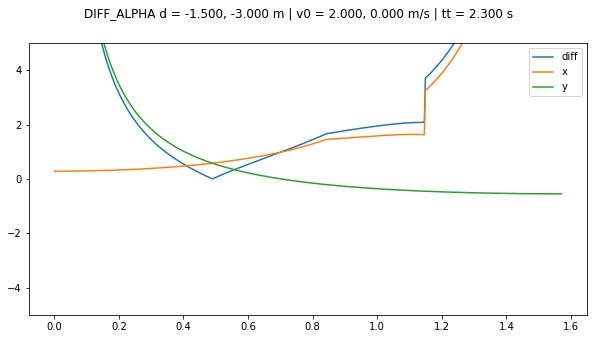

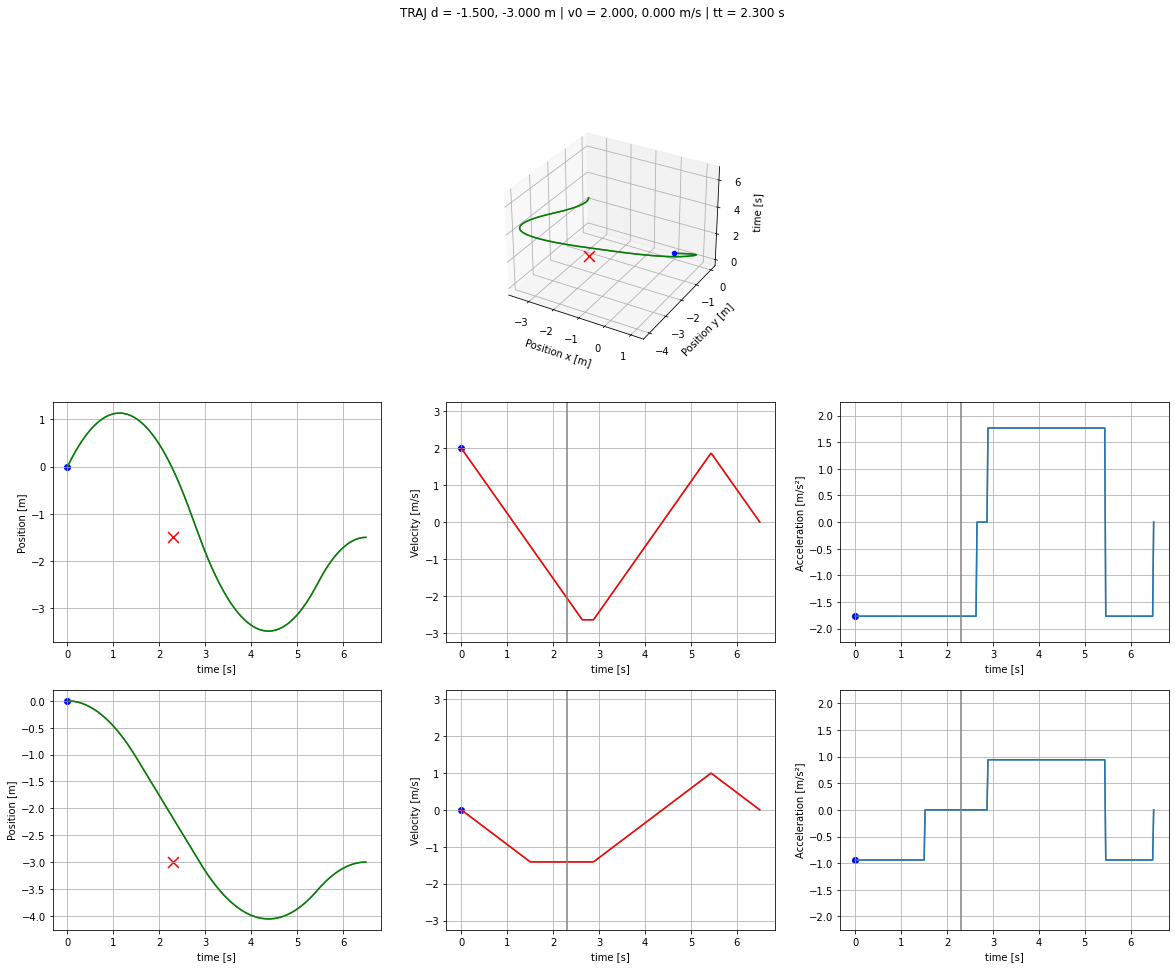

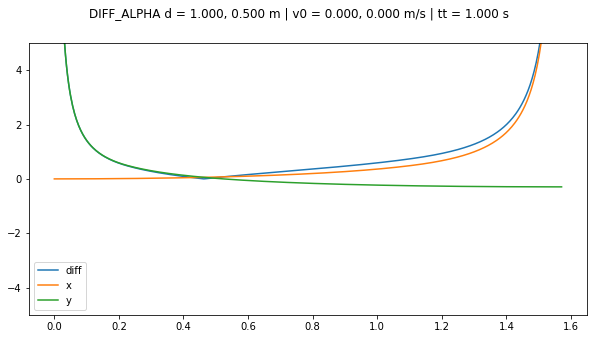

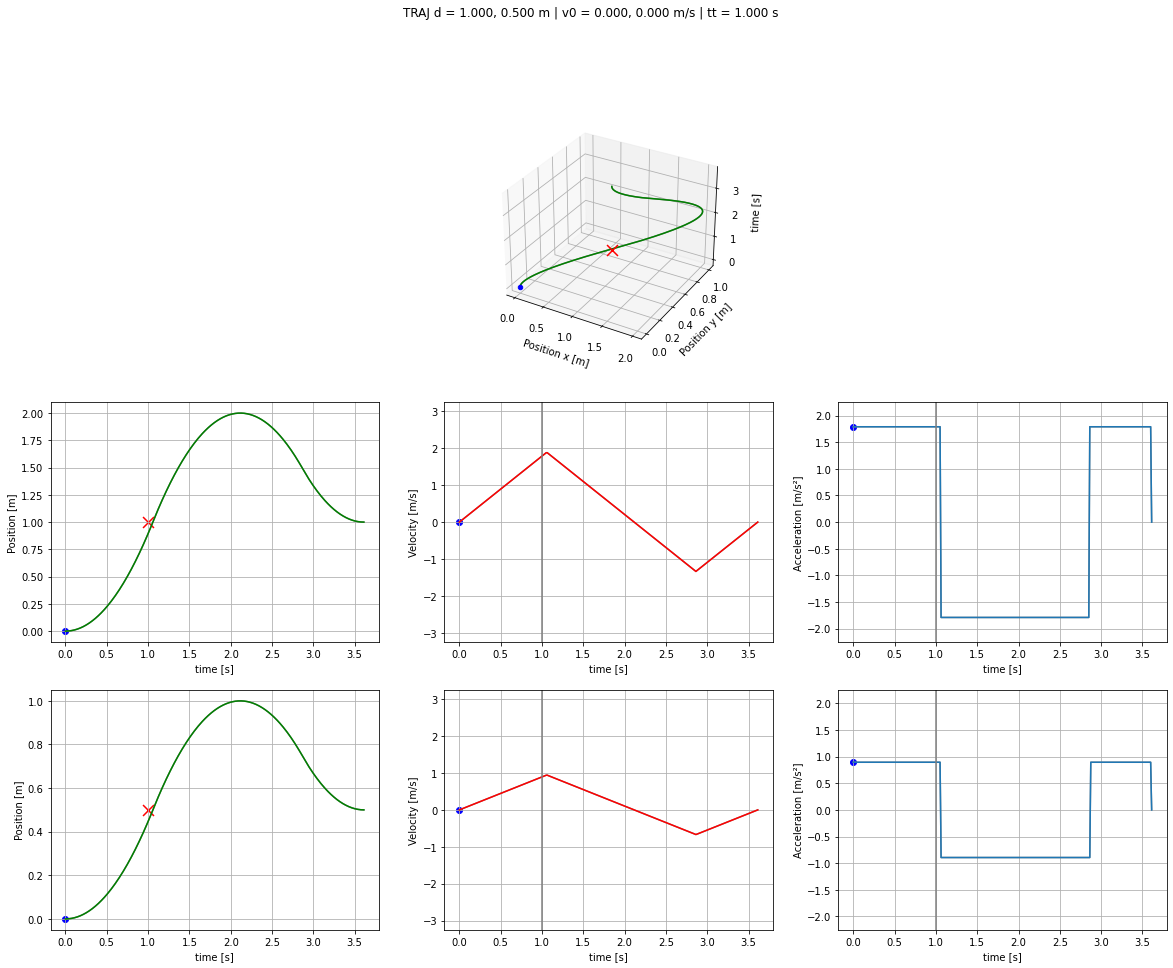

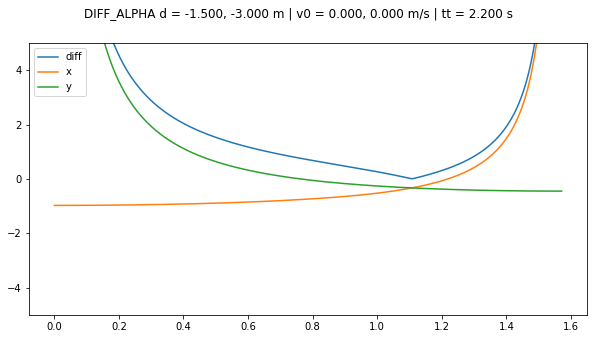

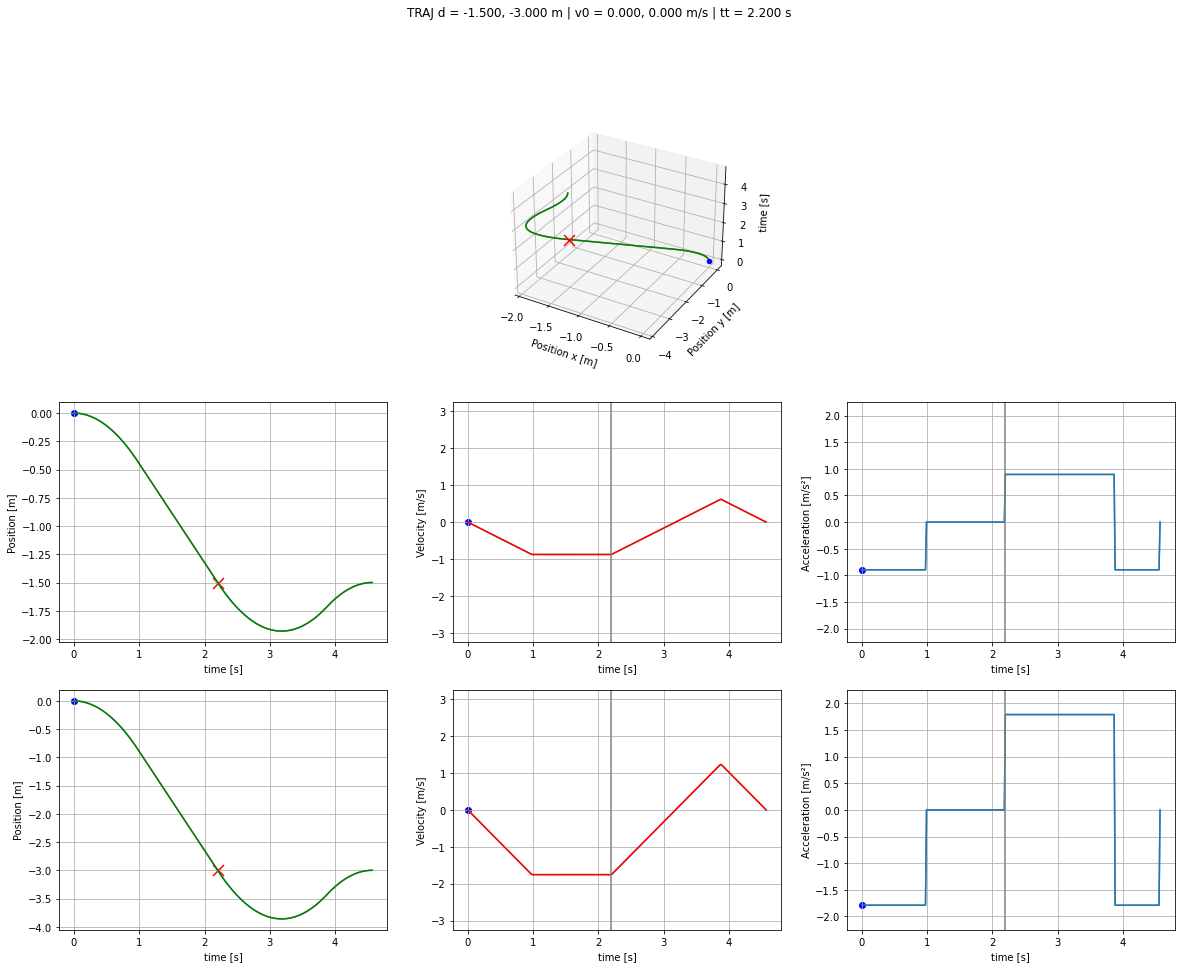

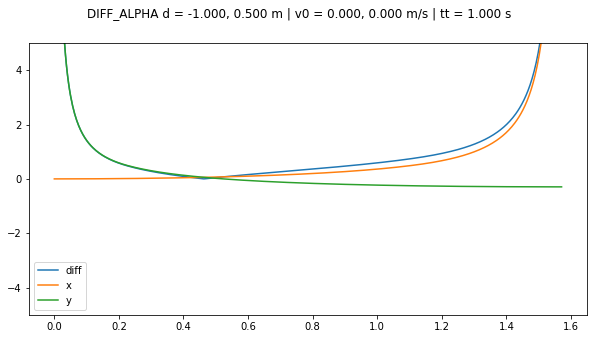

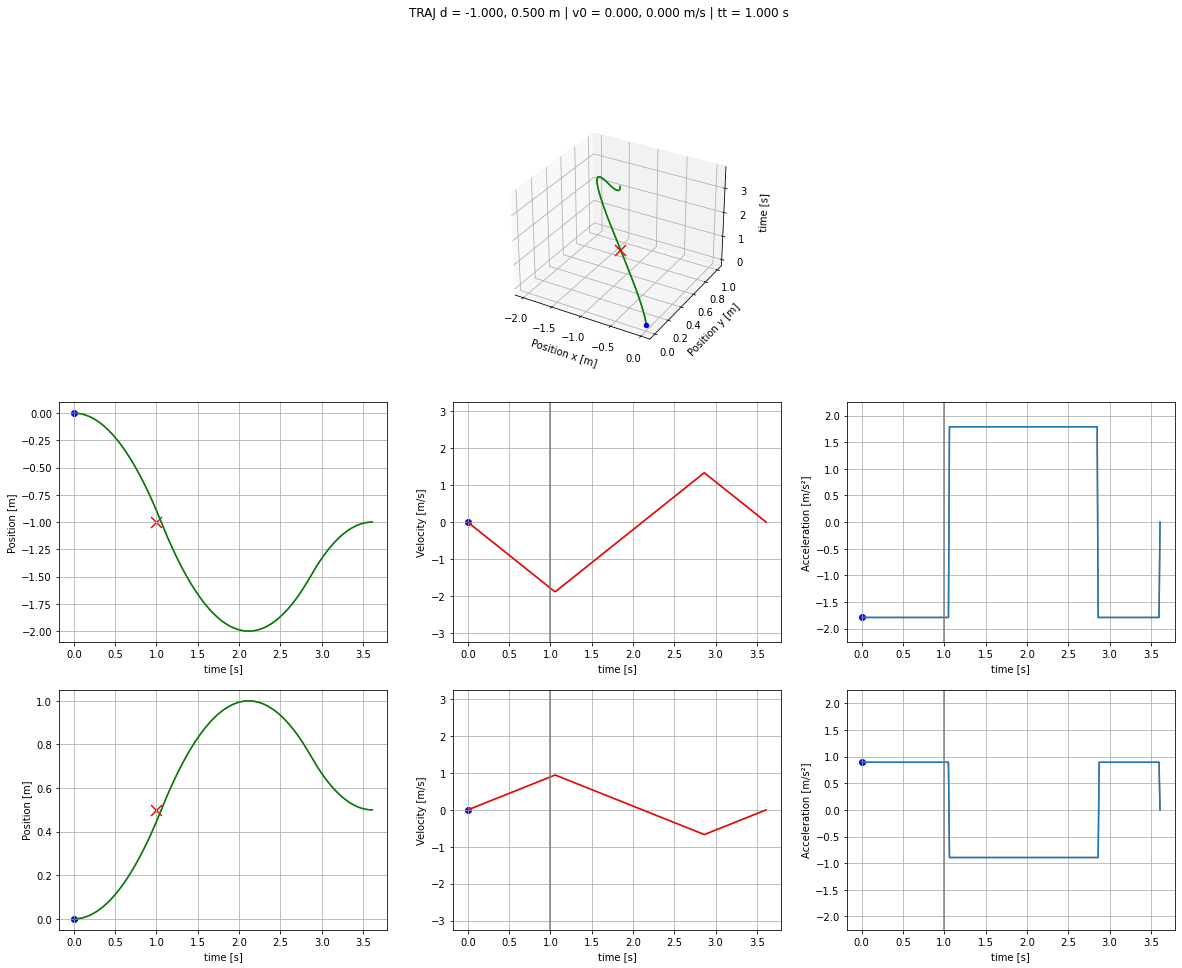

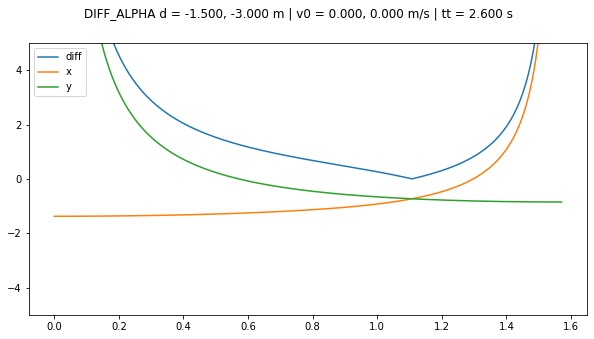

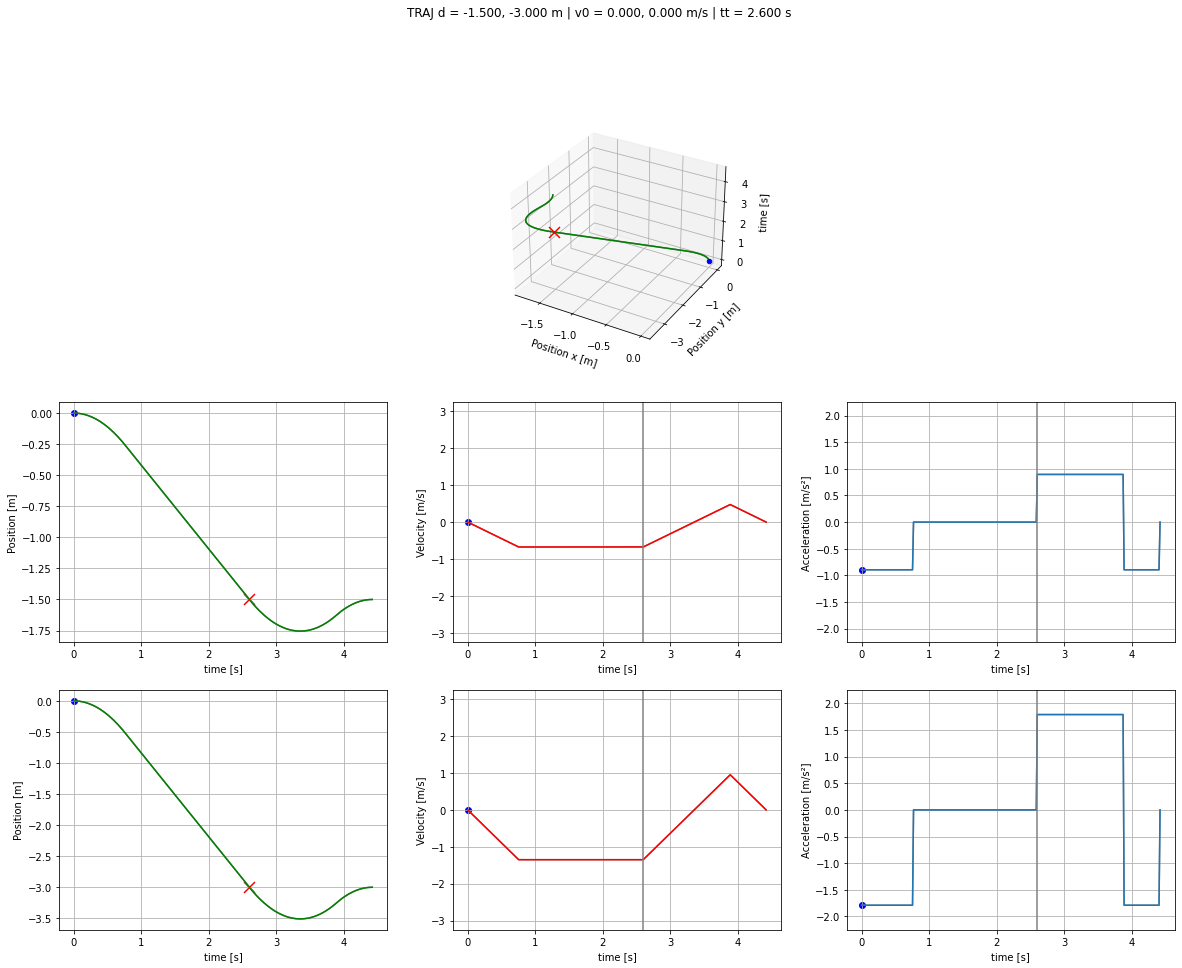

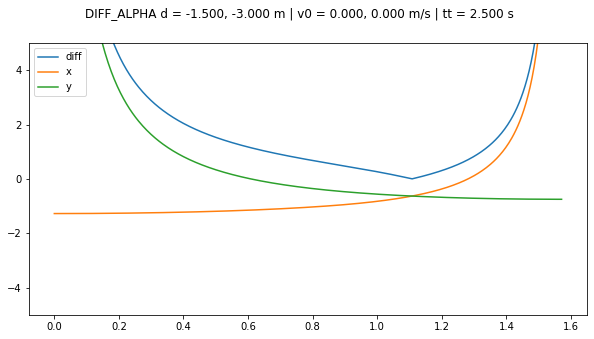

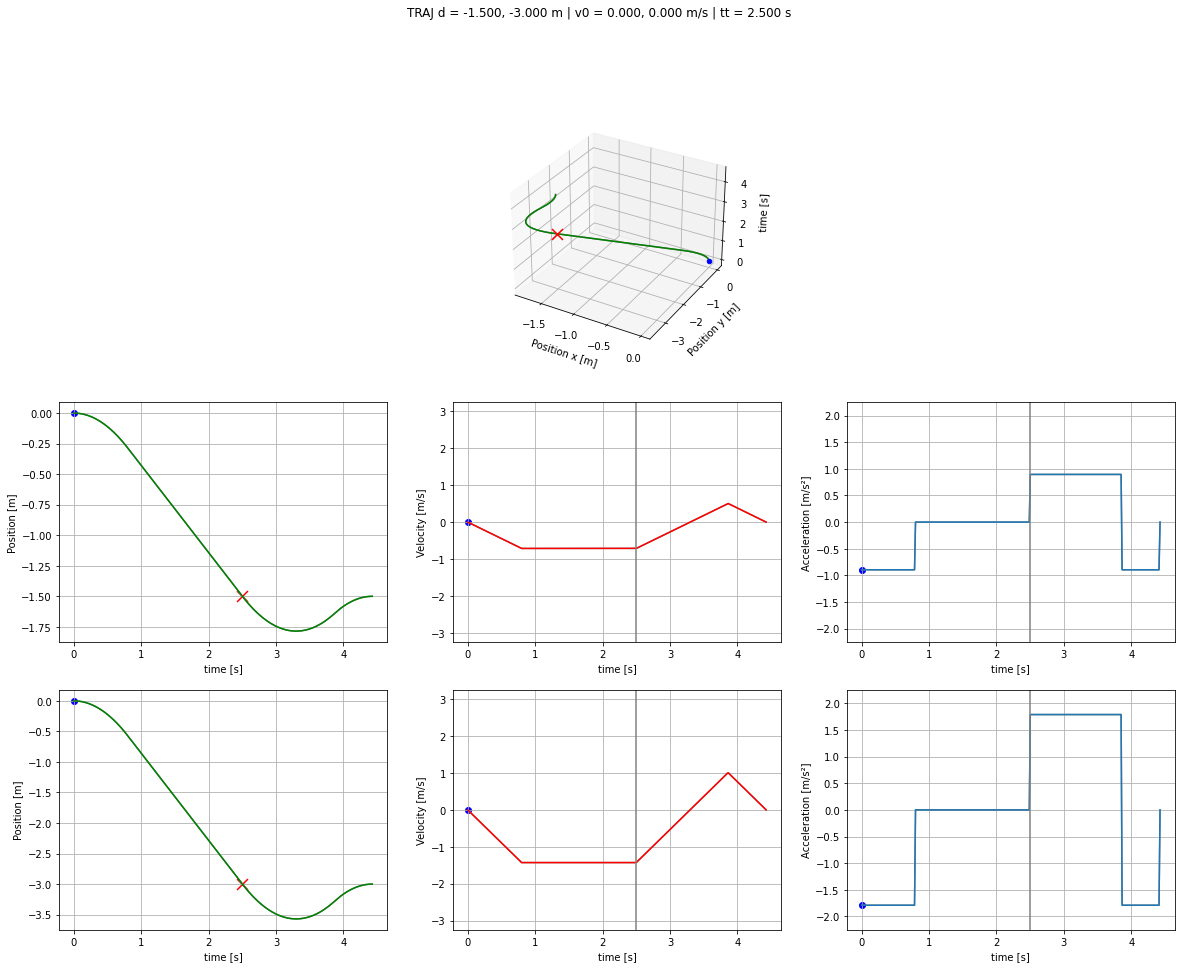

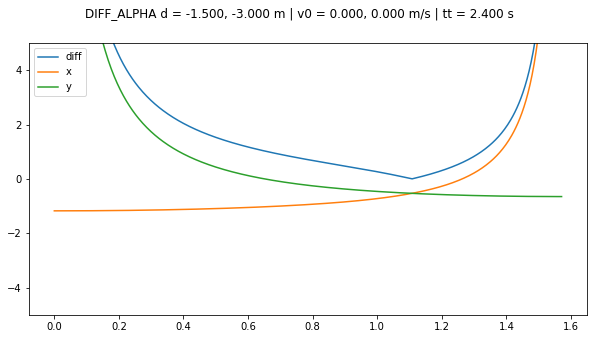

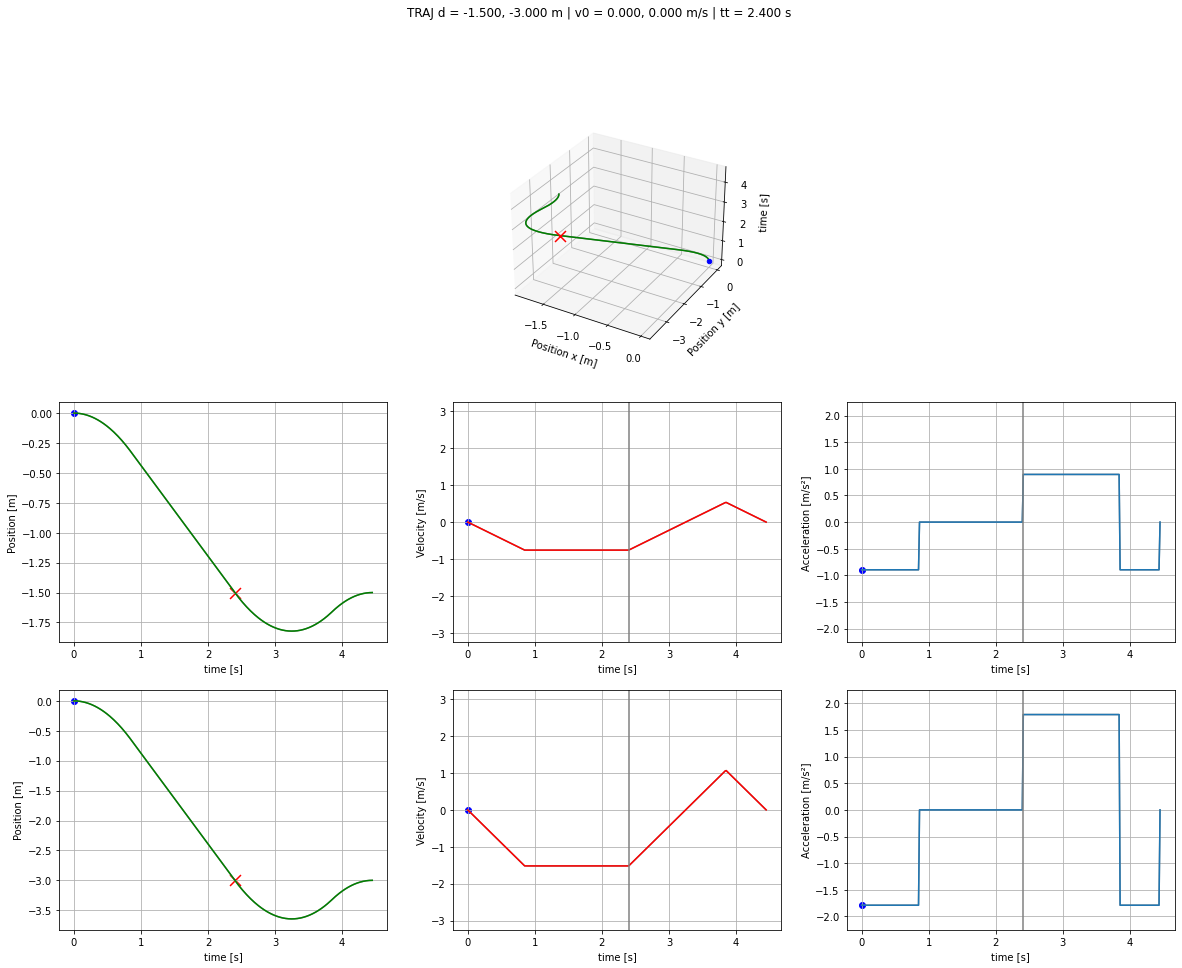

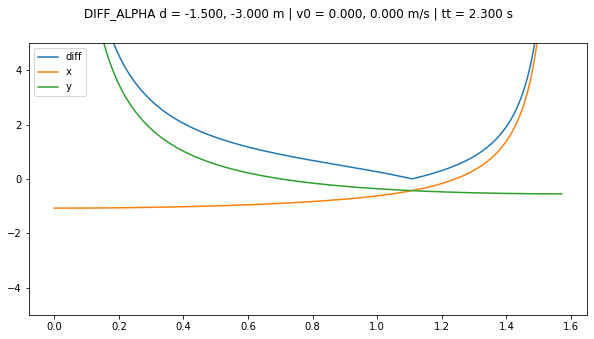

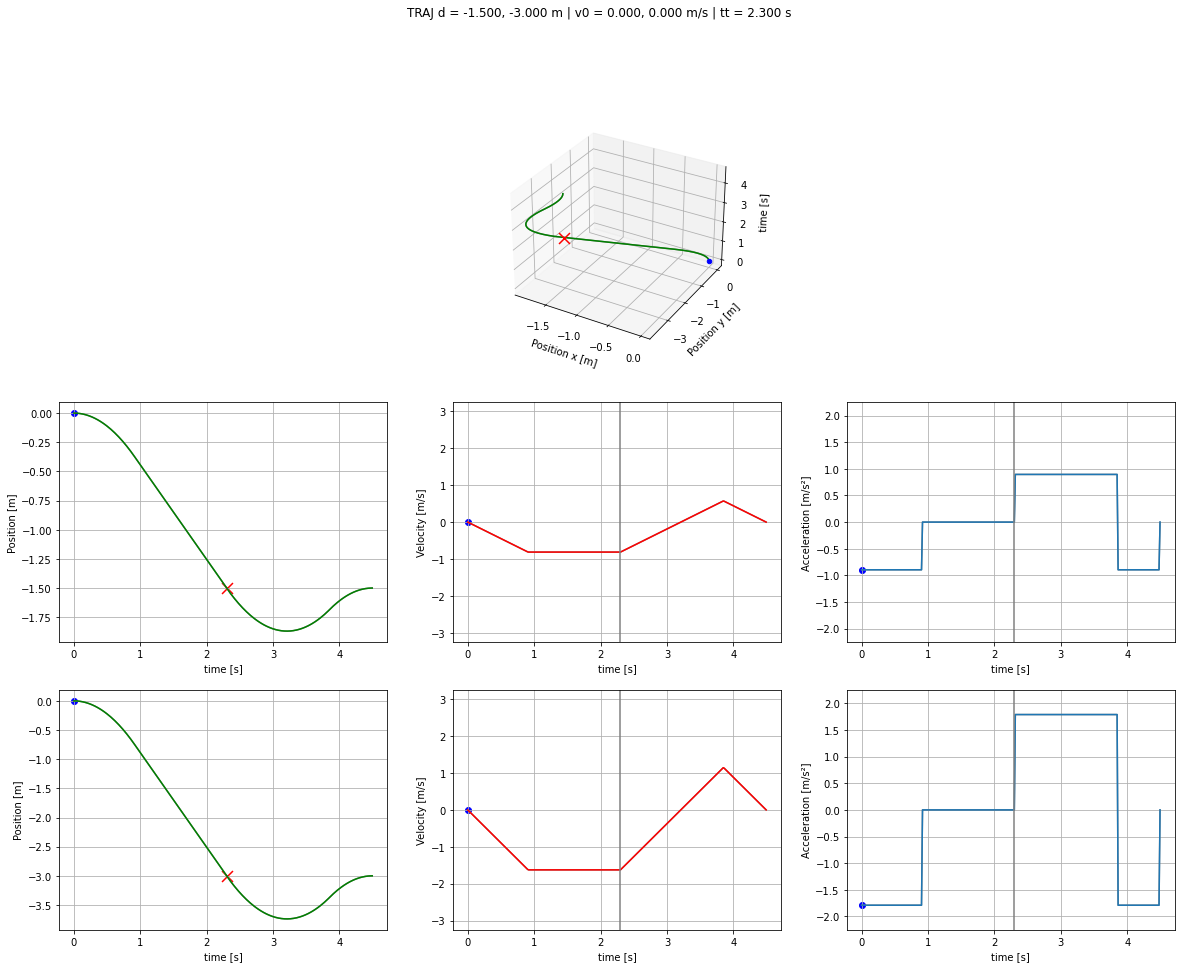

In [8]:
test_values = [
    ((-1.5, -3), (2, 0), 2.3),
    ((1, 0.5), (0, 0), 1),
    ((-1.5, -3), (0, 0), 2.2),
    ((-1, 0.5), (0, 0), 1),
    ((-1.5, -3), (0, 0), 2.6),
    ((-1.5, -3), (0, 0), 2.5),
    ((-1.5, -3), (0, 0), 2.4),
    ((-1.5, -3), (0, 0), 2.3),
]

for value in test_values:
    distance = Vec2(*value[0])
    initial_vel = Vec2(*value[1])
    target_time = value[2]
    Plotter.plot(distance, initial_vel, target_time, max_vel, max_acc, PlotType.DIFF_ALPHA)
    Plotter.plot(distance, initial_vel, target_time, max_vel, max_acc, PlotType.TRAJ)

In [6]:
random.seed(0)
for _ in range(10):
    distance = random.uniform(-3, 3)
    v0 = random.uniform(-max_vel, max_vel)
    target_time = random.uniform(0, 3)

    try:
        sim_steps = Simulator(max_vel, max_acc, num_steps=40, step_size=5).simulate(distance, v0, target_time)
        assert math.isclose(sim_steps[-1].current_pos(), distance, abs_tol=1e-4, rel_tol=1e-4), "{} != {}".format(
            sim_steps[-1].current_pos(), distance)
    except Exception as e:
        print("{}, {}, {} failed".format(distance, v0, target_time))
        raise AssertionError(e)
print("Success!")

Success!


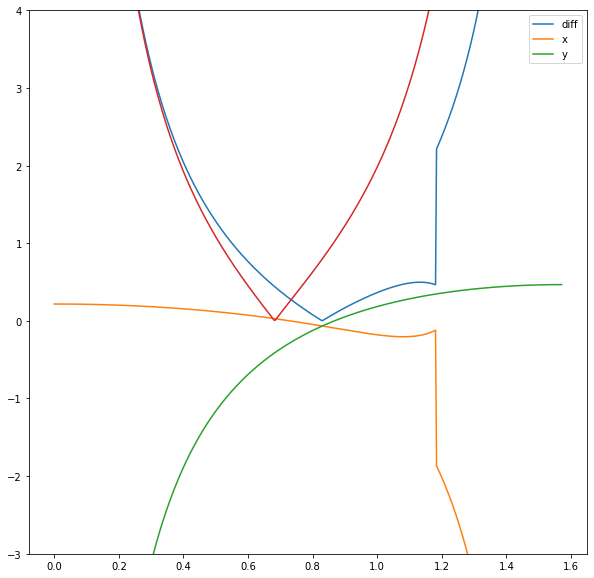

In [7]:
from traj1D import BangBangTrajectory1D


def diff_for_alpha_timed(alpha: float):
    initial_pos = Vec2(0, 0)
    final_pos = Vec2(-1.5, -3)
    initial_vel = Vec2(2, 0)
    target_time = 2.3

    s0x = initial_pos.x
    s0y = initial_pos.y
    s1x = final_pos.x
    s1y = final_pos.y
    v0x = initial_vel.x
    v0y = initial_vel.y

    sin_alpha = math.sin(alpha)
    cos_alpha = math.cos(alpha)

    max_vel_x = max_vel * cos_alpha
    max_vel_y = max_vel * sin_alpha

    max_acc_x = max_acc * cos_alpha
    max_acc_y = max_acc * sin_alpha

    _, _, _, time_remaining_x = BangBangTrajectory1D.can_reach(s0x, s1x, v0x, max_vel_x, max_acc_x, target_time)
    _, _, _, time_remaining_y = BangBangTrajectory1D.can_reach(s0y, s1y, v0y, max_vel_y, max_acc_y, target_time)

    return math.fabs(time_remaining_x - time_remaining_y), time_remaining_x, time_remaining_y


def diff_for_alpha_shortest(alpha: float):
    initial_pos = Vec2(0, 0)
    final_pos = Vec2(-1.5, -3)
    initial_vel = Vec2(2, 0)

    s0x = initial_pos.x
    s0y = initial_pos.y
    s1x = final_pos.x
    s1y = final_pos.y
    v0x = initial_vel.x
    v0y = initial_vel.y

    sin_alpha = math.sin(alpha)
    cos_alpha = math.cos(alpha)

    max_vel_x = max_vel * cos_alpha
    max_vel_y = max_vel * sin_alpha

    max_acc_x = max_acc * cos_alpha
    max_acc_y = max_acc * sin_alpha

    x = BangBangTrajectory1D()
    y = BangBangTrajectory1D()

    x.generate(s0x, s1x, v0x, max_vel_x, max_acc_x, None)
    y.generate(s0y, s1y, v0y, max_vel_y, max_acc_y, None)

    return math.fabs(x.get_total_time() - y.get_total_time())


alphas = np.linspace(1e-4, math.pi * 0.5 - 1e-4, num=500)
diffs_timed = [diff_for_alpha_timed(a) for a in alphas]
diffs_shortest = [diff_for_alpha_shortest(a) for a in alphas]

plt.rcParams['figure.figsize'] = [10, 10]
plt.ylim([-3, 4])
plt.plot(alphas, diffs_timed, label=("diff", "x", "y"))
plt.plot(alphas, diffs_shortest)
plt.legend()
plt.show()
